# Project \#1 - 🍿 Investigate a Movie Rental Database

## Introduction

For this project, I will use SQL to query the Sakila DVD rental database. It is a sample database originally created by MySQL that holds information about a fictional movie rental company. The goal of this project is to explore the database by asking interesting questions in order to gain a deeper understanding of the company and their customer base. The resulting queries and their insights would then be used to provide the rental company's marketing team with data-driven recommendations.

This project was completed usworking within PostgreSQL.

## Project Requirements

The final submission will include 4 questions of interest, each with a supporting SQL query needed to answer the questions posed. Each query will have a supporting visualization coupled with a small summary explaining the findings. In addition, the following criteria must be met:

- Each submitted query must contain **1 JOIN** and **1 Aggregation**
- **At least 2** of the queries must involve either a **subquery** or **CTE**
- **At least 1** of the queries must contain a **Window Function**
- **At least 1 column** generated from the Window Function should be included in one of the visualizations

## Entity Relationship Diagram

Below is the ERD of the Sakila DVD rental database.

---
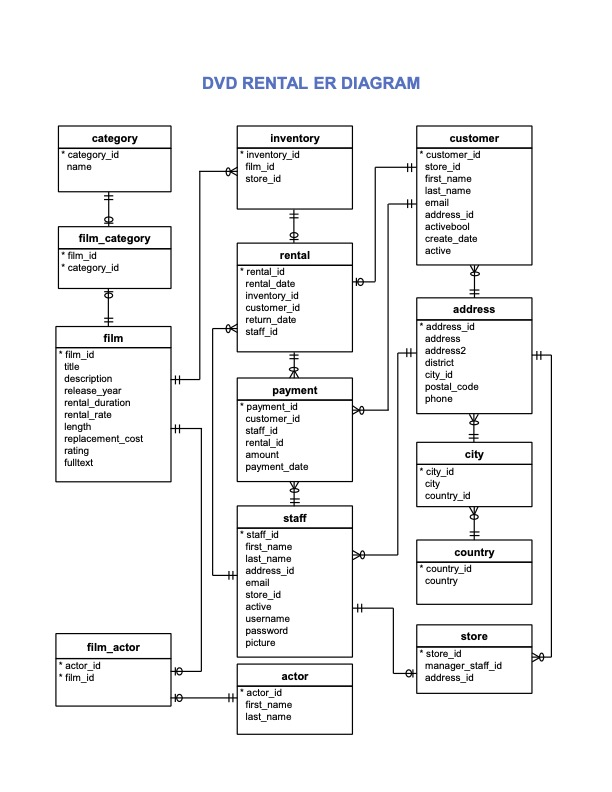

---

In [1]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

---
## Question \#1

### Which movie categories have the highest average number of DVD copies & rentals per title?

In determining the most popular movie categories in the movie rental database, I have decided to make 2 comparisons:

   1) The highest average number of DVD copies from unique titles between the categories
   2) The highest average number of rentals per title for movies between the categories

Instead of using the total number of individual titles and total number of DVD rentals as an indicator of a category's popularity, I feel as though comparing the averages could more accurately reflect a category's popularity, as some movie categories could have a higher total number of unique titles, and/or more DVD rental copies available for rent.

A quick query of the _film_ table shows 1000 unique titles in the database,

```sql
SELECT COUNT(*)
    FROM film
```

| count |
| --- |
| 1000 |

while the _inventory_ table contains 4581 DVD copies in stock.

```sql
SELECT COUNT(*)
    FROM inventory
```

| count |
| --- |
| 4581 |

Although these queries would suggest that there are 4,581 DVD copies spanning 1,000 unique titles, I want to run a query to find out if there are any movie titles in the database without any copies. That is to say, they exist in the database but are never actually rented since there are no associated copies available for those titles.

I will write a query to return the _film_id_ number for the movies with no inventory in the database. We will have to use a **LEFT JOIN** on the film table in order to return those films with 0 available DVD copies.

```sql
SELECT f.film_id as num
		FROM film f
		LEFT JOIN inventory i
		ON f.film_id = i.film_id
		WHERE i.inventory_id IS NULL
```

The query returned 42 movies that have 0 DVDs available for rent. These movie titles will be removed from our analysis, since we only want to include movies which have the **possibility** of being rented. Therefore, the number of unique titles in our database is 958 when removing those without available rental copies. This query can be nested within the **WHERE** clause to filter out these particular movies when running our subsequent queries.

Continuing on, we need to group these movie titles by their respective categories. Here is the query.

```sql
SELECT fc.category_id,
	   c.name as movie_category,
	   COUNT(fc.film_id) as unique_titles
FROM film f
JOIN film_category fc
ON f.film_id = fc.film_id
JOIN category c
ON c.category_id = fc.category_id
WHERE f.film_id NOT IN(SELECT sub.num FROM (
		SELECT f.film_id as num
		FROM film f
		LEFT JOIN inventory i
		ON f.film_id = i.film_id
		WHERE i.inventory_id IS NULL
	) sub )
GROUP BY 1, 2
```

| category_id | movie_category | unique_titles |
| --- | --- | --- |
| 9 | Foreign | 67 |
| 11 | Horror | 53 |
| 12 | Music | 51 |
| 13 | New | 60 |
| 2 | Animation | 64 |
| 4 | Classics | 54 |
| 15 | Sports | 73 |
| 8 | Family | 67 |
| 10 | Games | 58 |
| 7 | Drama | 61 |
| 6 | Documentary | 63 |
| 14 | Sci-Fi | 59 |
| 5 | Comedy | 56 |
| 1 | Action | 61 |
| 3 | Children | 58 |
| 16 | Travel | 53 |

Now that we have our movie titles grouped by category, we need to run two separate queries to determine the total number of DVD copies per category, and the total number of DVD rentals on those available copies. The results from these queries will be needed to calculate the average number of DVD copies and rentals for our comparison.

_Query returning the **total number of DVD copies** by category:_

```sql
SELECT fc.category_id,
	   c.name as movie_category,
	   COUNT(c.name) as total_num_copies
FROM inventory i
JOIN film f
ON f.film_id = i.film_id
JOIN film_category fc
ON fc.film_id = f.film_id
JOIN category c
ON c.category_id = fc.category_id
GROUP BY 1, 2
```

| category_id | movie_category | total_num_copies |
| --- | --- | --- |
| 5 | Comedy | 269 |
| 10 | Games | 276 |
| 11 | Horror | 248 |
| 6 | Documentary | 294 |
| 1 | Action | 312 |
| 16 | Travel | 235 |
| 13 | New | 275 |
| 12 | Music | 232 |
| 3 | Children | 269 |
| 2 | Animation | 335 |
| 8 | Family | 310 |
| 7 | Drama | 300 |
| 14 | Sci-Fi | 312 |
| 9 | Foreign | 300 |
| 4 | Classics | 270 |
| 15 | Sports | 344 |

_Query returning the **total number of rentals** by category:_

```sql 
SELECT fc.category_id,
	   c.name as movie_category,
	   COUNT(i.inventory_id) as total_rentals
FROM film f
JOIN film_category fc
ON f.film_id = fc.film_id
JOIN category c
ON c.category_id = fc.category_id
JOIN inventory i
ON i.film_id = f.film_id
JOIN rental r
ON r.inventory_id = i.inventory_id
GROUP BY 1, 2
```

| category_id | movie_category | total_rentals |
| --- | --- | --- |
| 5 | Comedy | 941 |
| 10 | Games | 969 |
| 11 | Horror | 846 |
| 6 | Documentary | 1050 |
| 1 | Action | 1112 |
| 16 | Travel | 837 |
| 13 | New | 940 |
| 12 | Music | 830 |
| 3 | Children | 945 |
| 2 | Animation | 1166 |
| 8 | Family | 1096 |
| 7 | Drama | 1060 |
| 14 | Sci-Fi | 1101 |
| 9 | Foreign | 1033 |
| 4 | Classics | 939 |
| 15 | Sports | 1179 |

In order to answer my original question and build the final query, we will have to **JOIN** all of these queries together. Our previous queries can become CTE's which will be joined on the _category_id_ and _movie_category_ columns. Since we are dividing the total number of copies and rentals by the number of unique titles, our results are highly likely to contain decimals and therefore we should use the **CAST** function to convert the datatype to a decimal before performing any arithmetic on the values.

The final results will be rounded to two decimal points. Here is the final query with its results. The query was limited to display only the top performing categories.

```sql
WITH tb1 AS (
SELECT fc.category_id,
	   c.name as movie_category,
	   COUNT(fc.film_id) as unique_titles
FROM film f
JOIN film_category fc
ON f.film_id = fc.film_id
JOIN category c
ON c.category_id = fc.category_id
WHERE f.film_id NOT IN(SELECT sub.num FROM (
		SELECT f.film_id as num
		FROM film f
		LEFT JOIN inventory i
		ON f.film_id = i.film_id
		WHERE i.inventory_id IS NULL
	) sub )
GROUP BY 1, 2
),

tb2 AS (	
SELECT fc.category_id,
	   c.name as movie_category,
	   COUNT(c.name) as total_num_copies
FROM inventory i
JOIN film f
ON f.film_id = i.film_id
JOIN film_category fc
ON fc.film_id = f.film_id
JOIN category c
ON c.category_id = fc.category_id
GROUP BY 1, 2
),

tb3 AS (
SELECT fc.category_id,
	   c.name as movie_category,
	   COUNT(i.inventory_id) as total_rentals
FROM film f
JOIN film_category fc
ON f.film_id = fc.film_id
JOIN category c
ON c.category_id = fc.category_id
JOIN inventory i
ON i.film_id = f.film_id
JOIN rental r
ON r.inventory_id = i.inventory_id
GROUP BY 1, 2
)

SELECT sub.movie_category,
	   ROUND(CAST(sub.total_num_copies as decimal) / sub.unique_titles, 2) as avg_copies_title,
	   ROUND(CAST(sub.total_rentals as decimal) / sub.unique_titles, 2) as avg_rentals_title
FROM (
	SELECT tb1.category_id,
		tb1.movie_category,
		tb1.unique_titles,
		tb2.total_num_copies,
		tb3.total_rentals
	FROM tb1
		JOIN tb2
		ON tb1.category_id = tb2.category_id
		AND tb1.movie_category = tb2.movie_category
		JOIN tb3
		ON tb3.category_id = tb2.category_id
		AND tb3.movie_category = tb2.movie_category
	) sub
ORDER BY 3 DESC
LIMIT 8;
```

| movie_category | avg_copies_title | avg_rentals_title |
| --- | --- | --- |
| Sci-Fi | 5.29 | 18.66 |
| Action | 5.11 | 18.23 |
| Animation | 5.23 | 18.22 |
| Classics | 5.00 | 17.39 |
| Drama | 4.92 | 17.38 |
| Comedy | 4.80 | 16.80 |
| Games | 4.76 | 16.71 |
| Documentary | 4.67 | 16.67 |

---
## Question \#2

### Which categories have the highest number of movie titles with more than 4 times total rentals-to-total copies?

To expand on the first question, I want to determine which categories have some of the most popular movies in the database. However, comparing movies by the total number of rentals isn't the most accurate method of measuring ones popularity. Instead, I would prefer to compare the ratio between the total number of rentals and the total number of DVD copies per movie title. Movie titles with fewer physical copies could be rented at a higher rate or turnover than movie titles that have higher numbers of individual copies, indicating a higher demand for those particular movies.

I decided to query the database to return the number of unique movie titles per category which have been rented at a rate **4 times or higher** than the number of DVD copies. Let's begin by writing a query returning the number of copies per movie, including the _category_id, film_id, movie_title, movie_category_ and the number of copies per title (_num_of_copies)_.

```sql
SELECT fc.category_id,
	   f.film_id,			   
	   f.title as movie_title,
	   c.name as movie_category,
	   COUNT(*) as num_of_copies
FROM inventory i
JOIN film f
ON f.film_id = i.film_id
JOIN film_category fc
ON fc.film_id = f.film_id
JOIN category c
ON c.category_id = fc.category_id
GROUP BY 1, 2, 3, 4
ORDER BY COUNT(*) DESC
```
| category_id | film_id	| movie_title | movie_category | num_of_copies |
| --- | --- | --- | --- | --- |
| 5 | 638 | Operation Operation | Comedy | 8 |
| 10 | 200 | Curtain Videotape | Games | 8 |
| 2	| 193 | Crossroads Casualties | Animation | 8 |
| 2 | 489 | Juggler Hardly | Animation | 8 |
| 14 | 350 | Garden Island | Sci-Fi | 8 |
| 6 | 206 | Dancing Fever | Documentary | 8 |
| 13 | 730 | Ridgemont Submarine | New | 8 |
| ... | ... | ... | ... | ... |

Next, we can query the database to return the number of times each movie title was rented, regardless of the number of copies per title. I will also return the _film_id_ number in this query as well, since I plan on joining this table to the previous query and will need to reference a common key.

```sql
SELECT i.film_id,
	   COUNT(i.inventory_id) as times_rented
FROM inventory i
JOIN rental r
ON i.inventory_id = r.inventory_id
JOIN film f
ON f.film_id = i.film_id
GROUP BY i.film_id
```

| film_id | times_rented |
| --- | --- |
| 251 | 18 |
| 106 | 7 |
| 681 | 21 |
| 285 | 30 |
| 120 | 9 |
| 866 | 8 |
| 887 | 19 |
| ... | ... |

We begin building the final query by joining our two previous queries on the _film_id_ columns, which can now be written as CTEs as _tb1 and tb2_, respectively. After joining the two CTEs and returning the _movie_title, movie_category, num_of_copies_ and _times_rented_ columns, I will use the **WHERE** clause to filter for those movies where the number of rentals is more than 4 times the number of DVD copies. Finally, we can use the **COUNT** function & **GROUPBY** clause to compare the movie categories in the database.

```sql
WITH tb1 AS (
SELECT fc.category_id,
	   f.film_id,			   
	   f.title as movie_title,
	   c.name as movie_category,
	   COUNT(*) as num_of_copies
FROM inventory i
JOIN film f
ON f.film_id = i.film_id
JOIN film_category fc
ON fc.film_id = f.film_id
JOIN category c
ON c.category_id = fc.category_id
GROUP BY 1, 2, 3, 4
ORDER BY COUNT(*) DESC
),

tb2 AS (
SELECT i.film_id,
	   COUNT(i.inventory_id) as times_rented
FROM inventory i
JOIN rental r
ON i.inventory_id = r.inventory_id
JOIN film f
ON f.film_id = i.film_id
GROUP BY i.film_id
)

SELECT sub.movie_category,
	   COUNT(sub.movie_category) as four_times_rental_to_copies
FROM (
	SELECT tb1.movie_title,
		tb1.movie_category,
		tb1.num_of_copies,
		tb2.times_rented
	FROM tb1
		JOIN tb2
		ON tb1.film_id = tb2.film_id
		WHERE times_rented > (num_of_copies * 4)
		ORDER BY tb2.times_rented DESC, tb1.movie_category
	) sub
GROUP BY 1
ORDER BY 1;
```

| movie_category | four_times_rental_to_copies |
| --- | --- |
| Action | 10 |
| Animation | 6 |
| Children | 8 |
| Classics | 4 | 
| Comedy | 10 |
| Documentary | 10 |
| Drama | 8 |
| Family | 11 |
| Foreign | 11 |
| Games | 7 |
| Horror | 6 |
| Music | 8 |
| New | 7 |
| Sci-Fi | 9 |
| Sports | 5 |
| Travel | 10 |

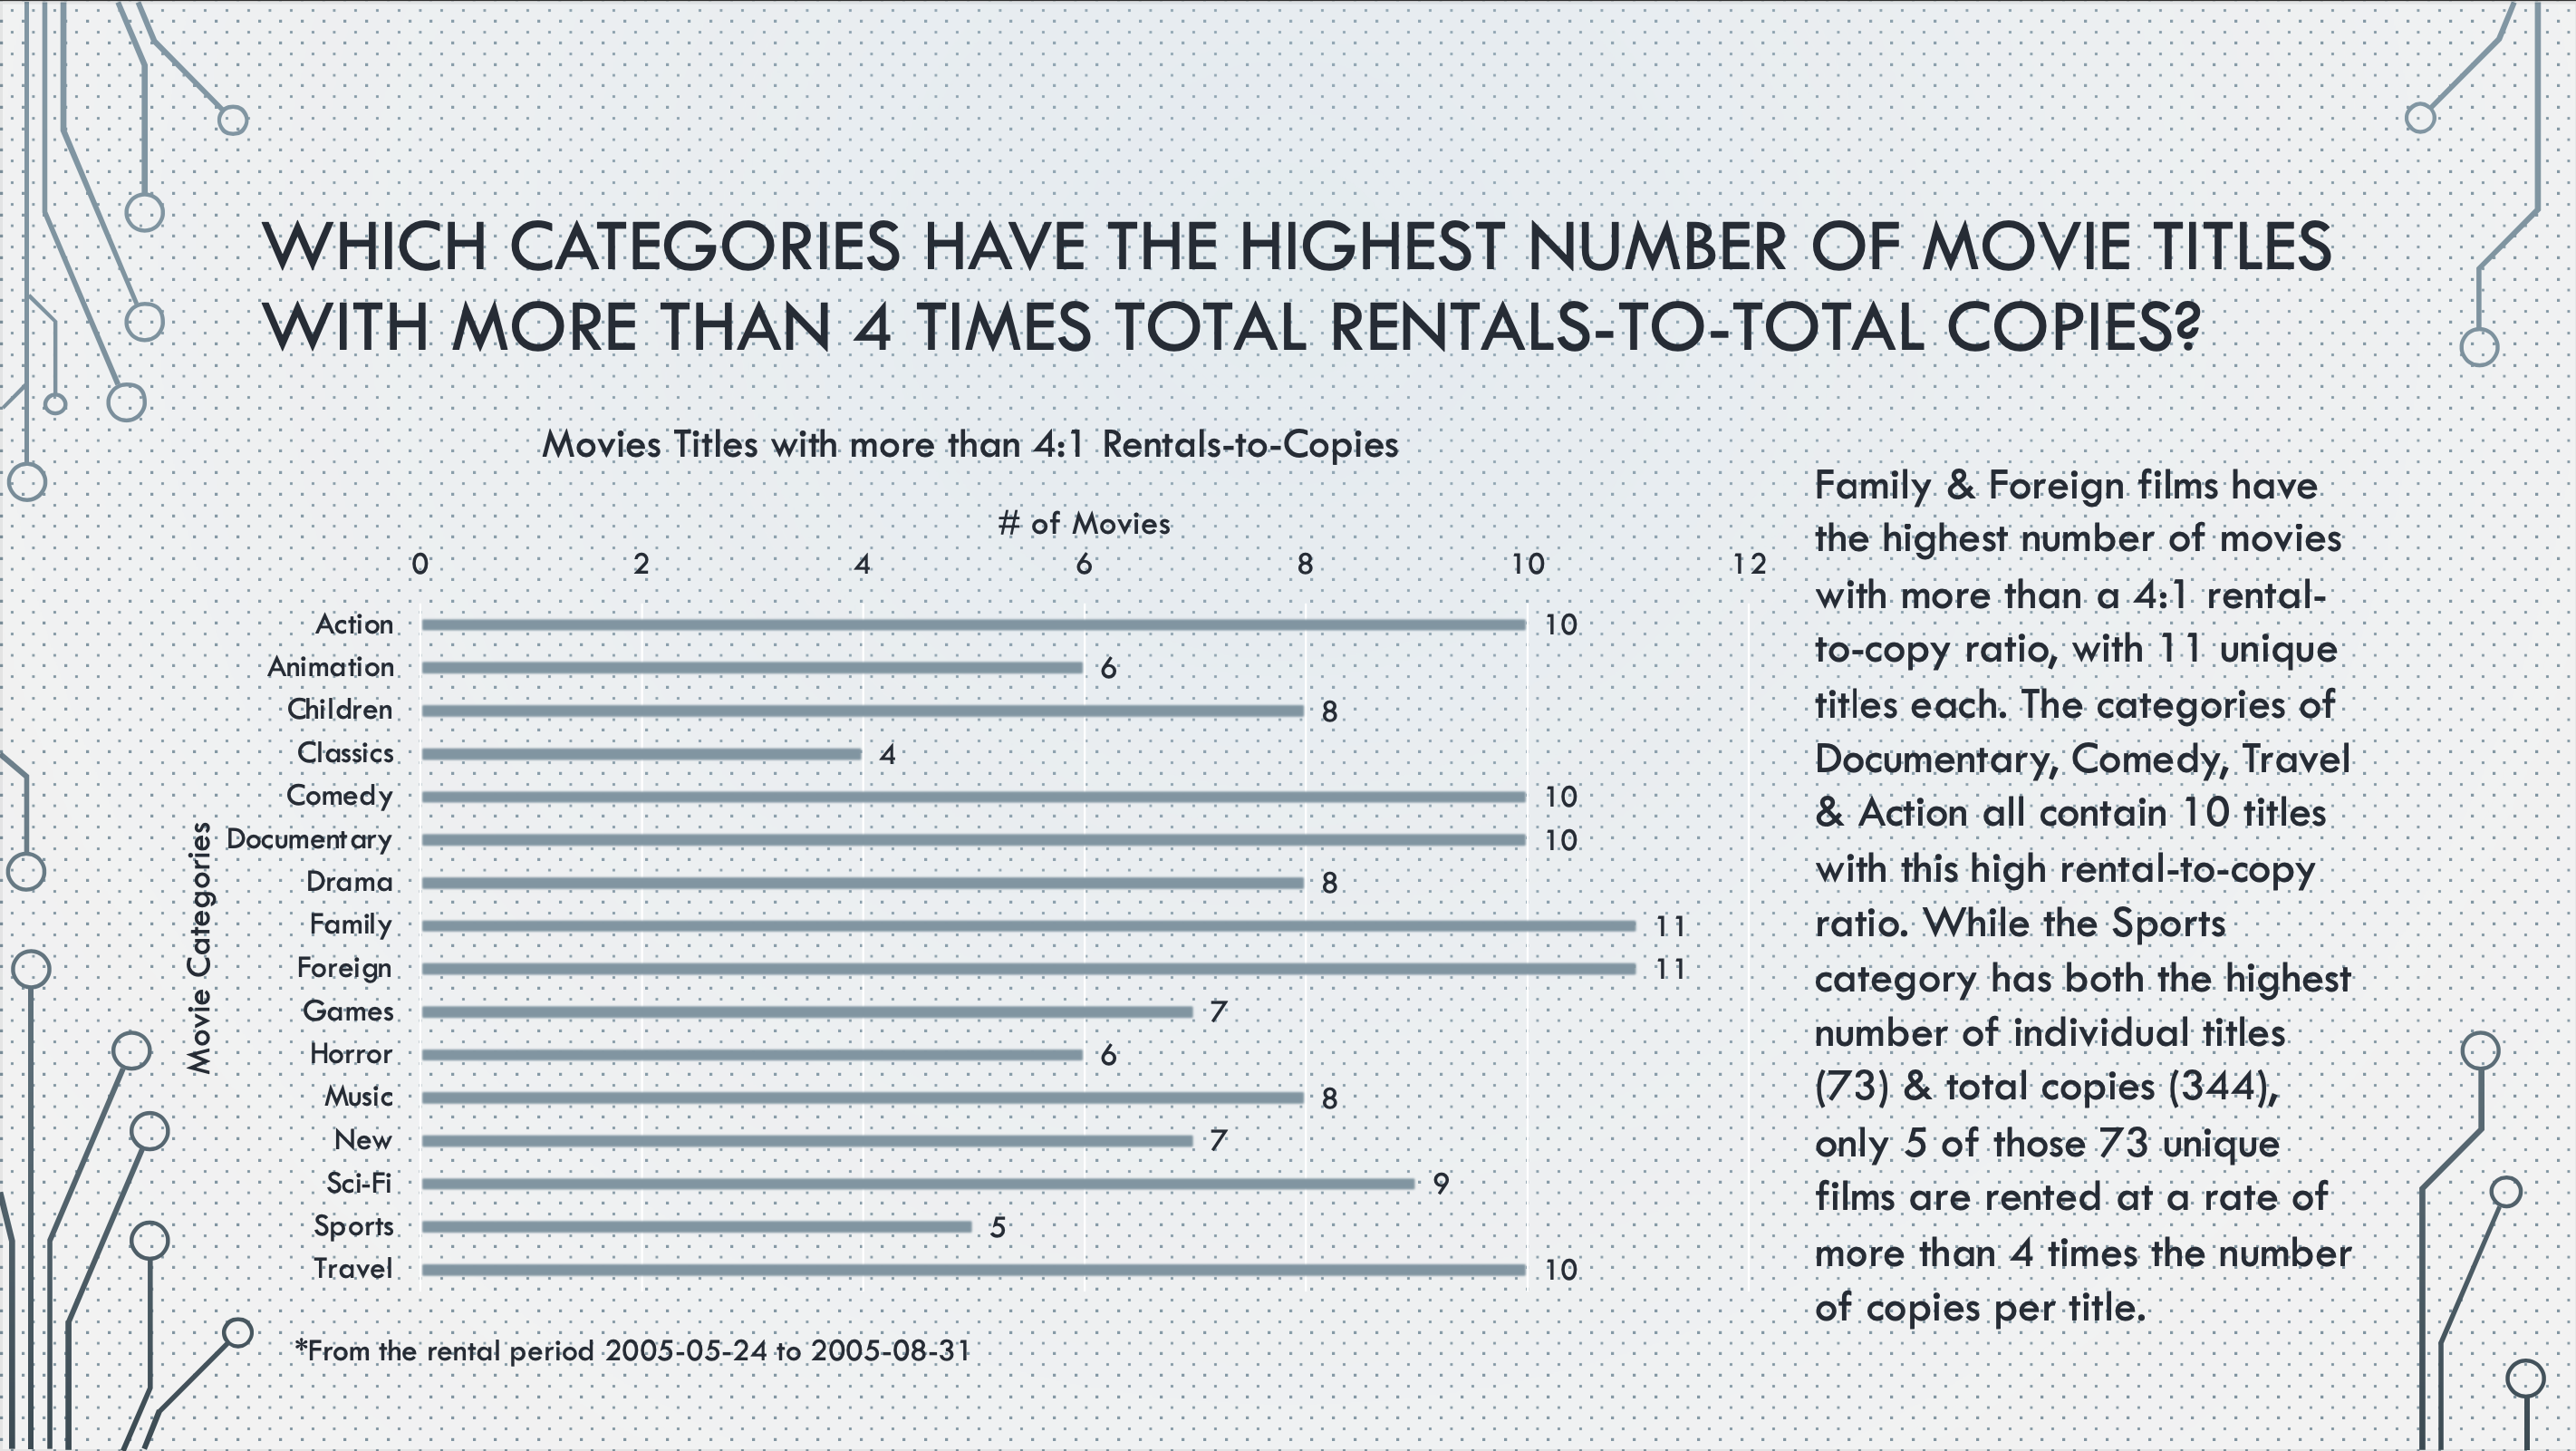

These titles with high rental rates could be further investigated to determine other reasons as to why they are so popular among customers. Grouping these titles by other criteria such as MPAA ratings, movie runtime, starring actors & actresses, and/or recurring key words within their movie descriptions could provide the team with additional insights and highlight any potential patterns for their popularity. Increasing the supply of these movies could also reduce the risk of having no copies available for rent from these popular titles.

---
## Question \#3

### Which categories have a higher average replacement cost value than the overall average cost?

In answering this question, our first task is to figure out what is the average replacement cost value of all of the movies in the database. Once again, we will be using our previous subquery to remove those movie titles that don’t have a physical copy available for rent. I want to return the _film_id_ and _title_, _category_id_ and _name_, as well as the _replacement_cost_ value. In addition, I only want to return each unique movie title and not every DVD rental copy related to each movie, since each title will have the same cost value. This can be achieved with the **DISTINCT** clause within the **SELECT** clause of our query.

```sql
SELECT DISTINCT f.film_id,
	   f.title as movie_title,
	   fc.category_id,
	   c.name as movie_category,
	   f.replacement_cost
FROM film f
JOIN film_category fc
ON f.film_id = fc.film_id
JOIN category c
ON c.category_id = fc.category_id
JOIN inventory i
ON f.film_id = i.film_id
JOIN rental r
ON r.inventory_id = i.inventory_id
WHERE f.film_id NOT IN(SELECT sub.num FROM (
		SELECT f.film_id as num
		FROM film f
		LEFT JOIN inventory i
		ON f.film_id = i.film_id
		WHERE i.inventory_id IS NULL
		) sub )
```

We can now place this query in a FROM statement to pull the average replacement cost value using the **AVG** function. This query will become our CTE from which we will compare against each genre's average values later.

```sql
WITH tb1 AS (
SELECT AVG(replacement_cost) as avg_replace_cost
FROM (
    SELECT DISTINCT f.film_id,
           f.title as movie_title,
           fc.category_id,
           c.name as movie_category,
           f.replacement_cost
    FROM film f
    JOIN film_category fc
    ON f.film_id = fc.film_id
    JOIN category c
    ON c.category_id = fc.category_id
    JOIN inventory i
    ON f.film_id = i.film_id
    JOIN rental r
    ON r.inventory_id = i.inventory_id
    WHERE f.film_id NOT IN(SELECT sub.num FROM (
            SELECT f.film_id as num
            FROM film f
            LEFT JOIN inventory i
            ON f.film_id = i.film_id
            WHERE i.inventory_id IS NULL
            ) sub )
        ) sub2
)
```

Next, we can copy this previous query entirely and query the average replacement cost value for each of the movie categories, rounding to 2 decimal points. Finally, we will use a **HAVING** clause to return only those movie categories with replacement values higher than the database average. Below is the final query and it's output, with the movie category values displayed in descending order. 

```sql
WITH tb1 AS (
SELECT AVG(replacement_cost) as avg_replace_cost
FROM (
    SELECT DISTINCT f.film_id,
           f.title as movie_title,
           fc.category_id,
           c.name as movie_category,
           f.replacement_cost
    FROM film f
    JOIN film_category fc
    ON f.film_id = fc.film_id
    JOIN category c
    ON c.category_id = fc.category_id
    JOIN inventory i
    ON f.film_id = i.film_id
    JOIN rental r
    ON r.inventory_id = i.inventory_id
    WHERE f.film_id NOT IN(SELECT sub.num FROM (
            SELECT f.film_id as num
            FROM film f
            LEFT JOIN inventory i
            ON f.film_id = i.film_id
            WHERE i.inventory_id IS NULL
            ) sub )
        ) sub2
    )
SELECT 	movie_category,
	ROUND(AVG(replacement_cost), 2) as avg_cost_per_catg
FROM (
    SELECT DISTINCT f.film_id,
           f.title as movie_title,
           fc.category_id,
           c.name as movie_category,
           f.replacement_cost
    FROM film f
    JOIN film_category fc
    ON f.film_id = fc.film_id
    JOIN category c
    ON c.category_id = fc.category_id
    JOIN inventory i
    ON f.film_id = i.film_id
    JOIN rental r
    ON r.inventory_id = i.inventory_id
    WHERE f.film_id NOT IN(SELECT sub.num FROM (
            SELECT f.film_id as num
            FROM film f
            LEFT JOIN inventory i
            ON f.film_id = i.film_id
            WHERE i.inventory_id IS NULL
        ) sub )
    ) sub2
GROUP BY 1
HAVING AVG(replacement_cost) > (SELECT * FROM tb1)
ORDER BY 2 DESC;
```

| movie_category | avg_cost_per_catg |
| --- | --- |
| Sci-Fi | 21.35 |
| Classics | 21.23 |
| Drama | 21.17 |
| Action | 21.01 |
| Games | 20.32 |
| Sports | 20.29 |
| Animation | 20.08 |



---

## Question \#4

### Do movies within the Sci-Fi category have consistent rental sales totals week-over-week?

For my final query I would like to incorporate a Window Function to measure the running rental sales totals week-over-week. I have chosen to focus my attention on the Sci-Fi movie category for this question. 

First, we can write a query that returns only the rentals pertaining to Sci-Fi movies and where the payment was received. I want to output both the _film_id_ and _inventory_id_ values, along with the movie _title, rental_date_ and _amount_. We will need to use the **DATE_TRUNC** function to truncate the dates into weeks for our analysis.

Here is the resulting query.

```sql
SELECT f.film_id,
	   r.inventory_id,
	   f.title,
	   r.rental_date,
	   p.amount as amount,
	   DATE_TRUNC('week', r.rental_date) as week
	FROM film f
	JOIN film_category fc
	ON f.film_id = fc.film_id
	JOIN category c
	ON c.category_id = fc.category_id
	JOIN inventory i
	ON i.film_id = f.film_id
	JOIN rental r
	ON r.inventory_id = i.inventory_id
	JOIN payment p
	ON p.rental_id = r.rental_id
	WHERE c.name = 'Sci-Fi' AND p.payment_id IS NOT NULL
	ORDER BY r.rental_date
```

The query returns 998 results. However, 8 of these transactions occurred in February of the following year, 6 months after the other 990 transactions. Since we are not given enough information regarding these late occurring transactions, I want to omit these outliers from the analysis and focus on the rental weeks starting from the first transaction in June until the end of August.

In order to group the sales by the week, let's nest our adjusted query that filters for the dates in the **FROM** clause. Below is our new query and the sales figures for each successive week.

```sql
SELECT DATE_TRUNC('week', sub.rental_date) as week,
	   SUM(amount) as amount_per_week
FROM (
	SELECT f.film_id,
		   r.inventory_id,
		   f.title,
		   r.rental_date,
		   p.amount as amount,
		   DATE_TRUNC('week', r.rental_date) as week
	FROM film f
	JOIN film_category fc
	ON f.film_id = fc.film_id
	JOIN category c
	ON c.category_id = fc.category_id
	JOIN inventory i
	ON i.film_id = f.film_id
	JOIN rental r
	ON r.inventory_id = i.inventory_id
	JOIN payment p
	ON p.rental_id = r.rental_id
	WHERE c.name = 'Sci-Fi' AND p.payment_id IS NOT NULL
	AND r.rental_date BETWEEN '2005-06-01' AND '2005-08-31'
	ORDER BY r.rental_date
) sub
GROUP BY 1
ORDER BY 1
)
```

| week | amount_per_week |
| --- | --- |
| 2005-06-13T00:00:00.000Z | 396.01 |
| 2005-06-20T00:00:00.000Z | 188.56 |
| 2005-07-04T00:00:00.000Z | 711.32 |
| 2005-07-11T00:00:00.000Z | 290.33 |
| 2005-07-25T00:00:00.000Z | 1011.73 |
| 2005-08-01T00:00:00.000Z | 400.16 |
| 2005-08-15T00:00:00.000Z | 909.91 |
| 2005-08-22T00:00:00.000Z | 397.08 |

Now we can incorporate a Window Function to calculte the running totals week-over-week for the movie category, highlighting any patterns that show consistent rental sales totals. The final query is below.

```sql
WITH tb1 AS (
SELECT DATE_TRUNC('week', sub.rental_date) as week,
	   SUM(amount) as amount_per_week
FROM (
	SELECT f.film_id,
		   r.inventory_id,
		   f.title,
		   r.rental_date,
		   p.amount as amount,
		   DATE_TRUNC('week', r.rental_date) as week
	FROM film f
	JOIN film_category fc
	ON f.film_id = fc.film_id
	JOIN category c
	ON c.category_id = fc.category_id
	JOIN inventory i
	ON i.film_id = f.film_id
	JOIN rental r
	ON r.inventory_id = i.inventory_id
	JOIN payment p
	ON p.rental_id = r.rental_id
	WHERE c.name = 'Sci-Fi' AND p.payment_id IS NOT NULL
	AND r.rental_date BETWEEN '2005-06-01' AND '2005-08-31'
	ORDER BY r.rental_date
) sub
GROUP BY 1
ORDER BY 1
)

SELECT tb1.week,
	   tb1.amount_per_week,
	   SUM(tb1.amount_per_week) OVER (ORDER BY tb1.week) AS running_total_amt
FROM tb1;
```

| week | amount_per_week | running_total_amt |
| --- | --- | --- |
| 2005-06-13T00:00:00.000Z | 396.01 | 396.01 |
| 2005-06-20T00:00:00.000Z | 188.56 | 584.57 |
| 2005-07-04T00:00:00.000Z | 711.32 | 1295.89 |
| 2005-07-11T00:00:00.000Z | 290.33 | 1586.22 |
| 2005-07-25T00:00:00.000Z | 1011.73 | 2597.95 |
| 2005-08-01T00:00:00.000Z | 400.16 | 2998.11 |
| 2005-08-15T00:00:00.000Z | 909.91 | 3908.02 |
| 2005-08-22T00:00:00.000Z | 397.08 | 4305.10 |